<a href="https://colab.research.google.com/github/bchuchucaa/RNNConsumoDeAgua/blob/main/LstmWaterConsumption1990_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Universidad Politecnica Salesiana

LSTM para prediccion del consumo de agua


# IMPORTACION DE LIBRERIAS

In [2]:
import pandas as pd
import numpy as np
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense,RepeatVector,TimeDistributed, GRU, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow import keras
#Librerias para graficos
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import pyplot
#Manejo de fechas
from datetime import datetime
from pandas.tseries.offsets import MonthBegin,MonthEnd

print('LIBRERIAS CORRECTAMENTE IMPORTADAS')

LIBRERIAS CORRECTAMENTE IMPORTADAS


##Lectura de datos

In [25]:
df_cpu_pivot = pd.read_csv('/content/1990-2021.csv')
df_cpu_pivot = df_cpu_pivot.rename(columns={'United States(USD)':'Jimmy Magguill','Europe(EUR)':'Michael Hermantrout','Japan(JPY)':'Kim Yanza','United Kingdom(GBP)':'Israel Canzas','Canada(CAD)':'Pablo Mendieta','Switzerland(CHF)':'Dominic Astudillo','India(INR)':'Ximena Robles','China(CNY)':'Angus Young','Turkey(TRY)':'Anderson Tay'})
df_cpu_pivot['Date'] = pd.to_datetime(df_cpu_pivot['Date'])
df_cpu_pivot.head(2)
df_cpu_pivot.shape

(379, 19)

# Data Exploration

In [28]:
print('Fecha de inicio :',df_cpu_pivot.Date.min(),'\n',' Fecha de fin : ',df_cpu_pivot.Date.max())

Fecha de inicio : 1990-01-31 00:00:00 
  Fecha de fin :  2021-07-30 00:00:00


In [27]:
trace1 = go.Scatter(
 x = df_cpu_pivot['Date'],
 y = df_cpu_pivot[df_cpu_pivot.columns[1]],
 mode = 'lines',
 name = df_cpu_pivot.columns[1]
)
trace2 = go.Scatter(
 x = df_cpu_pivot['Date'],
 y = df_cpu_pivot[df_cpu_pivot.columns[2]],
 mode = 'lines',
 name = df_cpu_pivot.columns[2]
)
trace3 = go.Scatter(
 x = df_cpu_pivot['Date'],
 y = df_cpu_pivot[df_cpu_pivot.columns[4]],
 mode = 'lines',
 name = df_cpu_pivot.columns[4]
)
layout = go.Layout(
 title = 'CONSUMO DE AGUA',
 xaxis = {'title' : 'Date'},
 yaxis = {'title' : 'Consumo'}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

##Separacion del dataset en conjunto de entranamiento y pruebas


In [32]:
train_test_split = datetime.strptime('01.12.2019', '%d.%m.%Y')
df_train = df_cpu_pivot.loc[df_cpu_pivot['Date'] < train_test_split]
df_test = df_cpu_pivot.loc[df_cpu_pivot['Date'] >= train_test_split]
cpu_list = [i for i in df_cpu_pivot.columns if i != 'Date']
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(df_train[cpu_list])
scaled_test = scaler.transform(df_test[cpu_list])

In [30]:
def split_sequence(sequence, look_back, forecast_horizon):
 X, y = list(), list()
 for i in range(len(sequence)):     
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
   X.append(seq_x)
   y.append(seq_y)   
 return np.array(X), np.array(y)

In [33]:
#Tomamos 3 meses y como salida el siguiente mes
LOOK_BACK = 4
FORECAST_RANGE = 4
n_features = len(cpu_list)
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(352, 4, 18)
(352, 4, 18)
(13, 4, 18)
(13, 4, 18)


In [34]:
checkpoint_filepath = 'path_to_checkpoint_filepath'
checkpoint_callback = ModelCheckpoint(   
 filepath=checkpoint_filepath,
 save_weights_only=False,
 monitor='val_loss',
 mode='min',
 save_best_only=True)
#Funcion para controlar la evolucion del error
early_stopping_callback = EarlyStopping(
 monitor='val_loss',
 min_delta=0.001,
 patience = 10,
 mode='min'
)
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.001, mode='min', patience=3, min_lr=0.0001)

In [35]:
#Funcion para obtener la transformacion inversa de los datos estandarizados
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse 

In [36]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)

In [37]:
def graph_predictions(y_test_inverse,yhat_inverse):
  label=list(range(0,len(y_test_inverse)))
  plt.plot(label, y_test_inverse, label = "Real")
  plt.plot(label, yhat_inverse, label = "Prediccion")
  plt.legend()
  plt.show()

# Entrenamiento del modelo y evaluacion del error



In [69]:
epochs = 500
batch_size = 21
validation = 0.0001


Epoch 1/500
17/17 [==============================] - 4s 54ms/step - loss: 0.0848 - mae: 0.2873 - val_loss: 0.3715 - val_mae: 0.8569 - lr: 0.0010
Epoch 2/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0650 - mae: 0.2396 - val_loss: 0.2134 - val_mae: 0.5560 - lr: 0.0010
Epoch 3/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0407 - mae: 0.1736 - val_loss: 0.1249 - val_mae: 0.3822 - lr: 0.0010
Epoch 4/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0233 - mae: 0.1231 - val_loss: 0.0664 - val_mae: 0.2630 - lr: 0.0010
Epoch 5/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0138 - mae: 0.0953 - val_loss: 0.0356 - val_mae: 0.2018 - lr: 0.0010
Epoch 6/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0081 - mae: 0.0779 - val_loss: 0.0250 - val_mae: 0.1801 - lr: 0.0010
Epoch 7/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0049 - mae: 0.0640 - val_loss: 0.0239 - val_mae: 0.1714 - lr

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 8s 501ms/step - loss: 0.0011 - mae: 0.0326 - val_loss: 0.0043 - val_mae: 0.0717 - lr: 1.0000e-04
Epoch 305/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0326 - val_loss: 0.0049 - val_mae: 0.0771 - lr: 1.0000e-04
Epoch 306/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0011 - mae: 0.0326 - val_loss: 0.0045 - val_mae: 0.0730 - lr: 1.0000e-04
Epoch 307/500
12/17 [====================>.........] - ETA: 0s - loss: 0.0011 - mae: 0.0318

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 8s 485ms/step - loss: 0.0011 - mae: 0.0324 - val_loss: 0.0038 - val_mae: 0.0680 - lr: 1.0000e-04
Epoch 308/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0011 - mae: 0.0330 - val_loss: 0.0045 - val_mae: 0.0739 - lr: 1.0000e-04
Epoch 309/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0325 - val_loss: 0.0047 - val_mae: 0.0755 - lr: 1.0000e-04
Epoch 310/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0328 - val_loss: 0.0039 - val_mae: 0.0684 - lr: 1.0000e-04
Epoch 311/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0323 - val_loss: 0.0042 - val_mae: 0.0713 - lr: 1.0000e-04
Epoch 312/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0325 - val_loss: 0.0042 - val_mae: 0.0710 - lr: 1.0000e-04
Epoch 313/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0325 - val_loss: 0.00

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 7s 448ms/step - loss: 0.0010 - mae: 0.0315 - val_loss: 0.0038 - val_mae: 0.0674 - lr: 1.0000e-04
Epoch 332/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0316 - val_loss: 0.0038 - val_mae: 0.0675 - lr: 1.0000e-04
Epoch 333/500
10/17 [================>.............] - ETA: 0s - loss: 0.0010 - mae: 0.0314    

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 8s 487ms/step - loss: 0.0010 - mae: 0.0315 - val_loss: 0.0035 - val_mae: 0.0648 - lr: 1.0000e-04
Epoch 334/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0316 - val_loss: 0.0040 - val_mae: 0.0690 - lr: 1.0000e-04
Epoch 335/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0314 - val_loss: 0.0038 - val_mae: 0.0675 - lr: 1.0000e-04
Epoch 336/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0314 - val_loss: 0.0037 - val_mae: 0.0666 - lr: 1.0000e-04
Epoch 337/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0010 - mae: 0.0313 - val_loss: 0.0041 - val_mae: 0.0701 - lr: 1.0000e-04
Epoch 338/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0010 - mae: 0.0314 - val_loss: 0.0038 - val_mae: 0.0673 - lr: 1.0000e-04
Epoch 339/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0313 - val_loss: 0.00

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 8s 489ms/step - loss: 0.0010 - mae: 0.0312 - val_loss: 0.0029 - val_mae: 0.0593 - lr: 1.0000e-04
Epoch 342/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0011 - mae: 0.0319 - val_loss: 0.0044 - val_mae: 0.0735 - lr: 1.0000e-04
Epoch 343/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0313 - val_loss: 0.0037 - val_mae: 0.0661 - lr: 1.0000e-04
Epoch 344/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0311 - val_loss: 0.0035 - val_mae: 0.0643 - lr: 1.0000e-04
Epoch 345/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0312 - val_loss: 0.0035 - val_mae: 0.0647 - lr: 1.0000e-04
Epoch 346/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0313 - val_loss: 0.0036 - val_mae: 0.0655 - lr: 1.0000e-04
Epoch 347/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0311 - val_loss: 0.00

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 7s 461ms/step - loss: 9.7292e-04 - mae: 0.0295 - val_loss: 0.0027 - val_mae: 0.0563 - lr: 1.0000e-04
Epoch 371/500
17/17 [==============================] - 0s 7ms/step - loss: 9.6002e-04 - mae: 0.0295 - val_loss: 0.0031 - val_mae: 0.0602 - lr: 1.0000e-04
Epoch 372/500
17/17 [==============================] - 0s 8ms/step - loss: 9.6016e-04 - mae: 0.0293 - val_loss: 0.0031 - val_mae: 0.0606 - lr: 1.0000e-04
Epoch 373/500
17/17 [==============================] - 0s 7ms/step - loss: 9.5946e-04 - mae: 0.0294 - val_loss: 0.0036 - val_mae: 0.0660 - lr: 1.0000e-04
Epoch 374/500
17/17 [==============================] - 0s 7ms/step - loss: 9.5457e-04 - mae: 0.0292 - val_loss: 0.0036 - val_mae: 0.0657 - lr: 1.0000e-04
Epoch 375/500
10/17 [================>.............] - ETA: 0s - loss: 9.5030e-04 - mae: 0.0290

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 8s 502ms/step - loss: 9.5790e-04 - mae: 0.0292 - val_loss: 0.0026 - val_mae: 0.0551 - lr: 1.0000e-04
Epoch 376/500
17/17 [==============================] - 0s 7ms/step - loss: 9.8717e-04 - mae: 0.0296 - val_loss: 0.0026 - val_mae: 0.0557 - lr: 1.0000e-04
Epoch 377/500
17/17 [==============================] - 0s 7ms/step - loss: 9.4283e-04 - mae: 0.0290 - val_loss: 0.0031 - val_mae: 0.0609 - lr: 1.0000e-04
Epoch 378/500
17/17 [==============================] - 0s 7ms/step - loss: 9.4086e-04 - mae: 0.0290 - val_loss: 0.0031 - val_mae: 0.0603 - lr: 1.0000e-04
Epoch 379/500
17/17 [==============================] - 0s 7ms/step - loss: 9.4119e-04 - mae: 0.0289 - val_loss: 0.0028 - val_mae: 0.0576 - lr: 1.0000e-04
Epoch 380/500
17/17 [==============================] - 0s 7ms/step - loss: 9.3924e-04 - mae: 0.0289 - val_loss: 0.0032 - val_mae: 0.0613 - lr: 1.0000e-04
Epoch 381/500
17/17 [==============================] - 0s 7ms/step - loss: 9.3671e-04 - 

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 8s 491ms/step - loss: 9.4103e-04 - mae: 0.0288 - val_loss: 0.0025 - val_mae: 0.0541 - lr: 1.0000e-04
Epoch 384/500
17/17 [==============================] - 0s 7ms/step - loss: 9.8913e-04 - mae: 0.0294 - val_loss: 0.0025 - val_mae: 0.0548 - lr: 1.0000e-04
Epoch 385/500
17/17 [==============================] - 0s 8ms/step - loss: 9.4042e-04 - mae: 0.0289 - val_loss: 0.0031 - val_mae: 0.0611 - lr: 1.0000e-04
Epoch 386/500
17/17 [==============================] - 0s 7ms/step - loss: 9.3039e-04 - mae: 0.0287 - val_loss: 0.0030 - val_mae: 0.0596 - lr: 1.0000e-04
Epoch 387/500
17/17 [==============================] - 0s 7ms/step - loss: 9.3832e-04 - mae: 0.0287 - val_loss: 0.0034 - val_mae: 0.0637 - lr: 1.0000e-04
Epoch 388/500
17/17 [==============================] - 0s 7ms/step - loss: 9.3167e-04 - mae: 0.0286 - val_loss: 0.0030 - val_mae: 0.0602 - lr: 1.0000e-04
Epoch 389/500
17/17 [==============================] - 0s 8ms/step - loss: 9.3176e-04 - 

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 7s 456ms/step - loss: 9.2508e-04 - mae: 0.0283 - val_loss: 0.0023 - val_mae: 0.0524 - lr: 1.0000e-04
Epoch 400/500
17/17 [==============================] - 0s 7ms/step - loss: 9.2402e-04 - mae: 0.0283 - val_loss: 0.0031 - val_mae: 0.0605 - lr: 1.0000e-04
Epoch 401/500
17/17 [==============================] - 0s 8ms/step - loss: 9.2166e-04 - mae: 0.0283 - val_loss: 0.0033 - val_mae: 0.0632 - lr: 1.0000e-04
Epoch 402/500
17/17 [==============================] - 0s 7ms/step - loss: 9.1181e-04 - mae: 0.0282 - val_loss: 0.0030 - val_mae: 0.0608 - lr: 1.0000e-04
Epoch 403/500
17/17 [==============================] - 0s 7ms/step - loss: 9.1133e-04 - mae: 0.0281 - val_loss: 0.0034 - val_mae: 0.0653 - lr: 1.0000e-04
Epoch 404/500
11/17 [==================>...........] - ETA: 0s - loss: 9.1012e-04 - mae: 0.0278

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 8s 499ms/step - loss: 9.1312e-04 - mae: 0.0281 - val_loss: 0.0023 - val_mae: 0.0524 - lr: 1.0000e-04
Epoch 405/500
17/17 [==============================] - 0s 7ms/step - loss: 9.1235e-04 - mae: 0.0281 - val_loss: 0.0027 - val_mae: 0.0573 - lr: 1.0000e-04
Epoch 406/500
17/17 [==============================] - 0s 7ms/step - loss: 9.0532e-04 - mae: 0.0279 - val_loss: 0.0026 - val_mae: 0.0560 - lr: 1.0000e-04
Epoch 407/500
17/17 [==============================] - 0s 7ms/step - loss: 9.0493e-04 - mae: 0.0280 - val_loss: 0.0035 - val_mae: 0.0662 - lr: 1.0000e-04
Epoch 408/500
17/17 [==============================] - 0s 7ms/step - loss: 9.1558e-04 - mae: 0.0281 - val_loss: 0.0030 - val_mae: 0.0602 - lr: 1.0000e-04
Epoch 409/500
17/17 [==============================] - 0s 7ms/step - loss: 9.1272e-04 - mae: 0.0280 - val_loss: 0.0024 - val_mae: 0.0527 - lr: 1.0000e-04
Epoch 410/500
12/17 [====================>.........] - ETA: 0s - loss: 9.1011e-04 - mae:

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 8s 488ms/step - loss: 9.3568e-04 - mae: 0.0282 - val_loss: 0.0020 - val_mae: 0.0496 - lr: 1.0000e-04
Epoch 411/500
17/17 [==============================] - 0s 7ms/step - loss: 9.1925e-04 - mae: 0.0282 - val_loss: 0.0029 - val_mae: 0.0592 - lr: 1.0000e-04
Epoch 412/500
17/17 [==============================] - 0s 8ms/step - loss: 8.9971e-04 - mae: 0.0279 - val_loss: 0.0029 - val_mae: 0.0586 - lr: 1.0000e-04
Epoch 413/500
17/17 [==============================] - 0s 7ms/step - loss: 9.0237e-04 - mae: 0.0278 - val_loss: 0.0026 - val_mae: 0.0552 - lr: 1.0000e-04
Epoch 414/500
17/17 [==============================] - 0s 8ms/step - loss: 8.9196e-04 - mae: 0.0277 - val_loss: 0.0028 - val_mae: 0.0583 - lr: 1.0000e-04
Epoch 415/500
17/17 [==============================] - 0s 7ms/step - loss: 8.9662e-04 - mae: 0.0278 - val_loss: 0.0029 - val_mae: 0.0590 - lr: 1.0000e-04
Epoch 416/500
17/17 [==============================] - 0s 7ms/step - loss: 8.9310e-04 - 

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 7s 454ms/step - loss: 8.9732e-04 - mae: 0.0276 - val_loss: 0.0020 - val_mae: 0.0490 - lr: 1.0000e-04
Epoch 425/500
17/17 [==============================] - 0s 7ms/step - loss: 8.9169e-04 - mae: 0.0277 - val_loss: 0.0032 - val_mae: 0.0625 - lr: 1.0000e-04
Epoch 426/500
17/17 [==============================] - 0s 7ms/step - loss: 8.8256e-04 - mae: 0.0275 - val_loss: 0.0023 - val_mae: 0.0525 - lr: 1.0000e-04
Epoch 427/500
17/17 [==============================] - 0s 7ms/step - loss: 8.8974e-04 - mae: 0.0276 - val_loss: 0.0028 - val_mae: 0.0584 - lr: 1.0000e-04
Epoch 428/500
17/17 [==============================] - 0s 7ms/step - loss: 8.9038e-04 - mae: 0.0276 - val_loss: 0.0030 - val_mae: 0.0604 - lr: 1.0000e-04
Epoch 429/500
17/17 [==============================] - 0s 7ms/step - loss: 8.8187e-04 - mae: 0.0274 - val_loss: 0.0023 - val_mae: 0.0521 - lr: 1.0000e-04
Epoch 430/500
17/17 [==============================] - 0s 7ms/step - loss: 8.8833e-04 - 

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 8s 500ms/step - loss: 8.4253e-04 - mae: 0.0265 - val_loss: 0.0019 - val_mae: 0.0478 - lr: 1.0000e-04
Epoch 489/500
17/17 [==============================] - 0s 7ms/step - loss: 8.5403e-04 - mae: 0.0267 - val_loss: 0.0022 - val_mae: 0.0515 - lr: 1.0000e-04
Epoch 490/500
17/17 [==============================] - 0s 7ms/step - loss: 8.5621e-04 - mae: 0.0268 - val_loss: 0.0027 - val_mae: 0.0582 - lr: 1.0000e-04
Epoch 491/500
17/17 [==============================] - 0s 9ms/step - loss: 8.4267e-04 - mae: 0.0265 - val_loss: 0.0022 - val_mae: 0.0516 - lr: 1.0000e-04
Epoch 492/500
17/17 [==============================] - 0s 8ms/step - loss: 8.4538e-04 - mae: 0.0265 - val_loss: 0.0021 - val_mae: 0.0501 - lr: 1.0000e-04
Epoch 493/500
17/17 [==============================] - 0s 7ms/step - loss: 8.3795e-04 - mae: 0.0264 - val_loss: 0.0022 - val_mae: 0.0523 - lr: 1.0000e-04
Epoch 494/500
17/17 [==============================] - 0s 7ms/step - loss: 8.3785e-04 - 

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 8s 491ms/step - loss: 8.4592e-04 - mae: 0.0265 - val_loss: 0.0017 - val_mae: 0.0443 - lr: 1.0000e-04
Epoch 499/500
17/17 [==============================] - 0s 7ms/step - loss: 8.4862e-04 - mae: 0.0266 - val_loss: 0.0027 - val_mae: 0.0576 - lr: 1.0000e-04
Epoch 500/500
17/17 [==============================] - 0s 7ms/step - loss: 8.5437e-04 - mae: 0.0268 - val_loss: 0.0025 - val_mae: 0.0552 - lr: 1.0000e-04
mae: tf.Tensor(0.13227063, shape=(), dtype=float32)
mse: tf.Tensor(0.031627156, shape=(), dtype=float32)


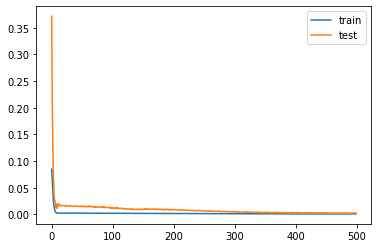

In [70]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(45)
np.random.seed(45)
model_enc_dec = tf.keras.models.Sequential()   
model_enc_dec.add(tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(LOOK_BACK, n_features)))     
model_enc_dec.add(tf.keras.layers.LSTM(60, return_sequences=True))
model_enc_dec.add(tf.keras.layers.LSTM(60, activation='relu', return_sequences=True))
model_enc_dec.add(tf.keras.layers.Dense(32,activation='relu'))
model_enc_dec.add(tf.keras.layers.Dense(32,activation='relu'))
model_enc_dec.add(tf.keras.layers.Dense(12,activation='relu'))
model_enc_dec.add(Dense(n_features))
model_enc_dec.compile(optimizer='adam', loss=tf.keras.losses.Huber(),metrics=["mae"])
plot_model(model=model_enc_dec, show_shapes=True)
history = model_enc_dec.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[ checkpoint_callback, rlrop_callback])
yhat = model_enc_dec.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test, yhat)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
#model_enc_dec.save_weights('mae0punto121.h5') 0.1322

Epoch 1/120
17/17 [==============================] - 4s 41ms/step - loss: 0.0844 - mae: 0.2865 - val_loss: 0.3580 - val_mae: 0.8363 - lr: 0.0010
Epoch 2/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0656 - mae: 0.2372 - val_loss: 0.2548 - val_mae: 0.6544 - lr: 0.0010
Epoch 3/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0470 - mae: 0.1951 - val_loss: 0.1519 - val_mae: 0.4792 - lr: 0.0010
Epoch 4/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0270 - mae: 0.1444 - val_loss: 0.0656 - val_mae: 0.2916 - lr: 0.0010
Epoch 5/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0141 - mae: 0.1022 - val_loss: 0.0293 - val_mae: 0.1840 - lr: 0.0010
Epoch 6/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0077 - mae: 0.0787 - val_loss: 0.0184 - val_mae: 0.1564 - lr: 0.0010
Epoch 7/120
17/17 [==============================] - 0s 10ms/step - loss: 0.0044 - mae: 0.0634 - val_loss: 0.0136 - val_mae: 0.1266 - l

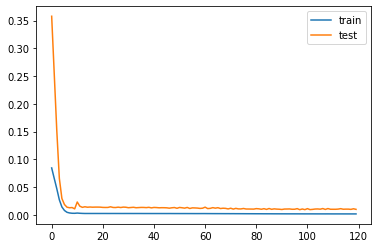

In [66]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(45)
np.random.seed(45)
model_enc_dec = tf.keras.models.Sequential()   
model_enc_dec.add(tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(LOOK_BACK, n_features)))     
model_enc_dec.add(LSTM(60, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(tf.keras.layers.LSTM(60, activation='relu', return_sequences=True))
model_enc_dec.add(tf.keras.layers.Dense(32,activation='relu'))
model_enc_dec.add(tf.keras.layers.Dense(32,activation='relu'))
model_enc_dec.add(tf.keras.layers.Dense(12,activation='relu'))
model_enc_dec.add(Dense(n_features))
model_enc_dec.compile(optimizer='adam', loss=tf.keras.losses.Huber(),metrics=["mae"])
plot_model(model=model_enc_dec, show_shapes=True)
history = model_enc_dec.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[ checkpoint_callback, rlrop_callback])
yhat = model_enc_dec.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test, yhat)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

ValueError: ignored

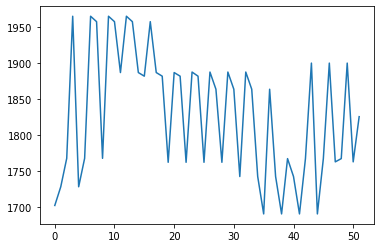

In [71]:
user=0
graph_predictions(y_test_inverse[:,user],yhat_inverse[:,user])
df_concat=pd.DataFrame({'real': y_test_inverse[:,user] , 'prediccion':yhat_inverse[:,user]})
df_concat.head(10)

# Nuevas predicciones

Predicciones nuevas de los Usuarios Segun las 3 ultima fechas saca la prediccion del nuevo mes de consumo

In [52]:
x_input = df_cpu_pivot.iloc[len(df_cpu_pivot)-LOOK_BACK:len(df_cpu_pivot),1:].values
x_input=scaler.transform(x_input)
x_input = x_input.reshape((1, LOOK_BACK, len(df_cpu_pivot.columns)-1))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [53]:
yhat = model_enc_dec.predict(x_input, verbose=0)
yhat = yhat.reshape(-1, yhat.shape[-1])
yhat = pd.DataFrame(scaler.inverse_transform(yhat))
yhat.insert(0, 'Date', pd.to_datetime(df_cpu_pivot['Date'].max(), format="%Y%m%d") + MonthBegin(1)+MonthEnd(1))

In [54]:
df_2_plot = df_cpu_pivot.copy()
yhat.columns=df_2_plot.columns
df_2_plot=df_2_plot.append(yhat,ignore_index=True)

Ingrese el numero de usuario que desea predecir3


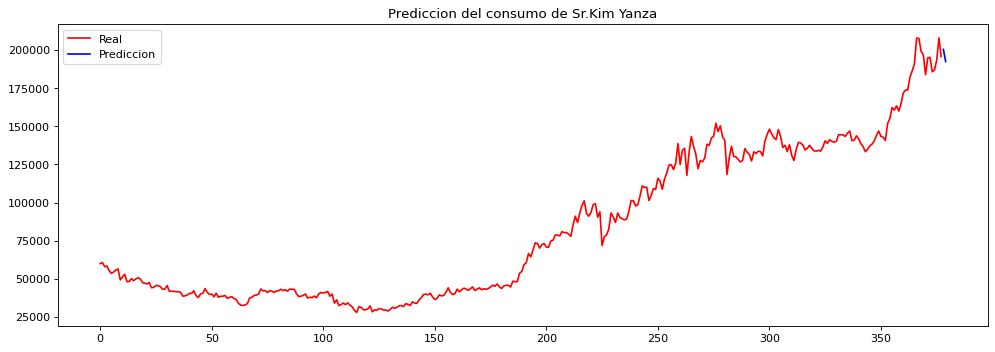

In [55]:
users=df_cpu_pivot.columns
select_user=int(input('Ingrese el numero de usuario que desea predecir'))
user=users[select_user]
from matplotlib.pyplot import figure
figure(figsize=(15, 5), dpi=80)
plt.plot(np.where(df_2_plot['Date']<df_cpu_pivot.Date.max(),df_2_plot[user], None), color="red", label="Real")
plt.plot(np.where(df_2_plot['Date']>=df_cpu_pivot.Date.max(),df_2_plot[user], None), color="blue", label="Prediccion")
plt.title("Prediccion del consumo de Sr."+user)
plt.legend()

In [46]:
df_2_plot.Date

0     1990-01-31
1     1990-02-28
2     1990-03-30
3     1990-04-30
4     1990-05-31
         ...    
375   2021-04-30
376   2021-05-31
377   2021-06-30
378   2021-07-30
379   2021-08-31
Name: Date, Length: 380, dtype: datetime64[ns]